# Examples of using Prompts as Composable Primitives

In this notebook we'll go through examples of leveraging prompts as primitives for learning environments.

In [ ]:
!pip install ipywidgets
!pip install matplotlib-inline
!pip install openai
!pip install openai
!pip install langchain
!pip install langchain_community
!pip install langchain_openai
!pip install langchainhub
!pip install chromadb
!pip install pypdf
!pip install tiktoken
!pip install pydantic
!pip install graphviz # might not work on google colab

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
from dotenv import load_dotenv
from openai import OpenAI

# loading from a .env file
# load_dotenv(dotenv_path="/full/path/to/your/.env")

# or 
# if you're on google colab just uncomment below and replace with your openai api key
# os.environ["OPENAI_API_KEY"] = "<your-openai-api-key>"

## Example 1 - Knowledge Graph Primitive

This example, taken from Jason Liu's talk: "Pydantic is all you need" shows how creating a knowledge graph can be as simple as a prompt coupled with some simple classes to handle construction of the graph plus some validation checks. 

In [1]:
# from pydantic import BaseModel, Field
from langchain.pydantic_v1 import BaseModel, Field
from typing import List
from graphviz import Digraph
import argparse
from langchain.output_parsers import PydanticOutputParser
import graphviz
from IPython.display import display

class Node(BaseModel):
    id: int
    label: str
    color: str

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

class KnowledgeGraph(BaseModel):
    """A knowledge graph is a graph that represents knowledge as a set of entities and relations between them."""
    nodes: List[Node] = Field(..., description="A list of nodes in the knowledge graph")
    edges: List[Edge] = Field(..., description="A list of edges in the knowledge graph")


def visualize_knowledge_graph(kg: KnowledgeGraph):
    dot = Digraph(comment="Knowledge Graph")

    # Add nodes
    for node in kg.nodes:
        dot.node(str(node.id), node.label, color=node.color)

    # Add edges
    for edge in kg.edges:
        dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)

    # Render the graph
    display(graphviz.Source(dot.source))

Now, let's modify the `chain_diagram()` function to output a schema that's appropriate for generating a knowledge graph.

In [8]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
openai_function_knowledge_graph = convert_pydantic_to_openai_function(KnowledgeGraph)

def chain_diagram(llm):
    return ChatPromptTemplate.from_template("Write a knowledge graph with the necessary concepts and elements to understand the following concept: '''{concept}''', this diagram should perfectly encapsulate\
        what it is and what it relates to.") | llm

llm_chat = ChatOpenAI()    
llm_with_tools = llm_chat.bind(functions=[openai_function_knowledge_graph])

chain = chain_diagram(llm_with_tools)
concept = "Transformer architecture in neural networks"

output_graph = chain.invoke({"concept": concept})
output_graph

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"nodes":[{"id":1,"label":"Transformer architecture","color":"#FF5733"},{"id":2,"label":"Neural Networks","color":"#33FF57"},{"id":3,"label":"Attention Mechanism","color":"#3393FF"},{"id":4,"label":"Encoder","color":"#FF33E6"},{"id":5,"label":"Decoder","color":"#33E6FF"}],"edges":[{"source":1,"target":2,"label":"is a part of"},{"source":1,"target":3,"label":"utilizes"},{"source":1,"target":4,"label":"consists of"},{"source":1,"target":5,"label":"consists of"}]}', 'name': 'KnowledgeGraph'}})

Ok, so we are getting the right output, which we can access like this:

In [9]:
output_graph.additional_kwargs["function_call"]["arguments"]

'{"nodes":[{"id":1,"label":"Transformer architecture","color":"#FF5733"},{"id":2,"label":"Neural Networks","color":"#33FF57"},{"id":3,"label":"Attention Mechanism","color":"#3393FF"},{"id":4,"label":"Encoder","color":"#FF33E6"},{"id":5,"label":"Decoder","color":"#33E6FF"}],"edges":[{"source":1,"target":2,"label":"is a part of"},{"source":1,"target":3,"label":"utilizes"},{"source":1,"target":4,"label":"consists of"},{"source":1,"target":5,"label":"consists of"}]}'

But we want this output to be perfectly tailored for a function that visualizes the graph, so let's do that. 

In [10]:
from langchain.output_parsers import PydanticOutputParser

pydantic_output_parser = PydanticOutputParser(pydantic_object=KnowledgeGraph)

output_graph_json_dict = output_graph.additional_kwargs["function_call"]["arguments"]
output_graph_json_dict 

'{"nodes":[{"id":1,"label":"Transformer architecture","color":"#FF5733"},{"id":2,"label":"Neural Networks","color":"#33FF57"},{"id":3,"label":"Attention Mechanism","color":"#3393FF"},{"id":4,"label":"Encoder","color":"#FF33E6"},{"id":5,"label":"Decoder","color":"#33E6FF"}],"edges":[{"source":1,"target":2,"label":"is a part of"},{"source":1,"target":3,"label":"utilizes"},{"source":1,"target":4,"label":"consists of"},{"source":1,"target":5,"label":"consists of"}]}'

In [11]:
pydantic_output_parser.parse(output_graph_json_dict)

KnowledgeGraph(nodes=[Node(id=1, label='Transformer architecture', color='#FF5733'), Node(id=2, label='Neural Networks', color='#33FF57'), Node(id=3, label='Attention Mechanism', color='#3393FF'), Node(id=4, label='Encoder', color='#FF33E6'), Node(id=5, label='Decoder', color='#33E6FF')], edges=[Edge(source=1, target=2, label='is a part of', color='black'), Edge(source=1, target=3, label='utilizes', color='black'), Edge(source=1, target=4, label='consists of', color='black'), Edge(source=1, target=5, label='consists of', color='black')])

Yay! As you can see above, the output of parsing with the pydantic_output_parser is the `KnowledgeGraph` object, which we can feed into the 
`visualize_graph` function to get the final output.

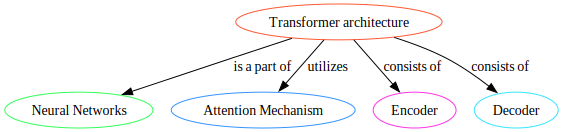

In [12]:
kg = pydantic_output_parser.parse(output_graph_json_dict)

visualize_knowledge_graph(kg)

Yaaay victory!!! Now, let's wrap this into a modified version of the original chain by using the RunnableLambda Object to do the 
intermediary step we were doing before.

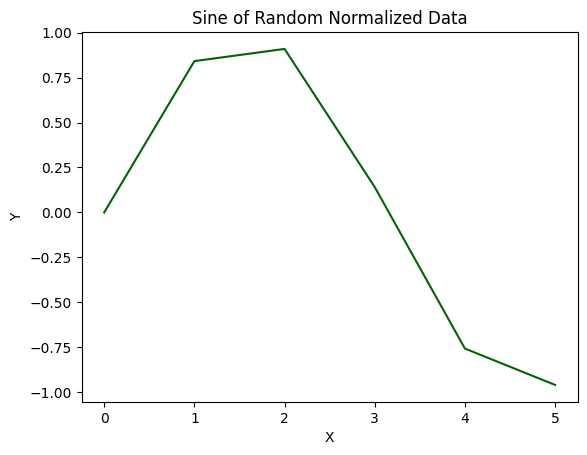

In [14]:
from pydantic import BaseModel, Field
from typing import List, Optional
from openai import OpenAI
import instructor
from IPython.display import display
from pydantic import BaseModel, Field
from typing import List
import matplotlib.pyplot as plt

client = instructor.patch(OpenAI())

class DataPlot(BaseModel):
    x_values: List[float]
    y_values: List[float]
    # hist_data: List[float]
    title: str
    x_label: str
    y_label: str
    plot_type: str = Field(default="line", description="Type of the plot (line, bar, scatter, hist)")
    # density: bool = Field(default=False, description="Density of histogram plot")
    # alpha: float = Field(default=0.7, description="Alpha of histogram plot")
    color: Optional[str] = Field(default=None, description="Color of the plot")
    marker: Optional[str] = Field(default=None, description="Marker style for scatter plot")

def generate_plot(input) -> DataPlot:
    return client.chat.completions.create(
        model="gpt-3.5-turbo-16k",
        messages=[
            {
                "role": "user",
                "content": f"Help me visualize this concept in a plot:{input}",
            }
        ],
        response_model=DataPlot,
    )  # type: ignore


def plot(dp: DataPlot):
    if dp.plot_type == "line":
        plt.plot(dp.x_values, dp.y_values, color=dp.color, marker=dp.marker)
    elif dp.plot_type == "bar":
        plt.bar(dp.x_values, dp.y_values, color=dp.color)
    elif dp.plot_type == "scatter":
        plt.scatter(dp.x_values, dp.y_values, color=dp.color, marker=dp.marker)
    else:
        raise ValueError("Unsupported plot type")

    plt.title(dp.title)
    plt.xlabel(dp.x_label)
    plt.ylabel(dp.y_label)
    plt.show()

def plot_primitive(prompt):
    dp = generate_plot(prompt)
    plot(dp)

# Example usage
plot_primitive("Plot the sine of a set of random normalized data as a dark green line")

We want more power of expression and we want flexiblity.